In [2]:
#!pip install tensorflow==1.14.0

In [3]:
#!pip install keras==2.2.5

In [4]:
import os
os.environ["PYTHONHASHSEED"] = "13"
os.environ["CUDA_VISIBLE_DEVICES"] = "0:1"

import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(13)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(13)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(13)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [5]:
print(K.tensorflow_backend._get_available_gpus())
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())



['/job:localhost/replica:0/task:0/device:GPU:0']
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14059270315617354248
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6458072097598693600
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16217862812332925325
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 251068416
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9988187556355637944
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5"
]


In [6]:
import gc
import warnings

#import lightgbm as lgb
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from tqdm.notebook import tqdm

import keras
from keras.models import Sequential
from keras.layers import BatchNormalization, Dense, Dropout

path_data = "../input/ashrae-energy-prediction/"
path_train = path_data + "train.csv"
path_test = path_data + "test.csv"
path_building = path_data + "building_metadata.csv"
path_weather_train = path_data + "weather_train.csv"
path_weather_test = path_data + "weather_test.csv"

myfavouritenumber = 13
seed = myfavouritenumber

warnings.filterwarnings("ignore")

In [7]:
site_id = 10

In [8]:
df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)

building = pd.read_csv(path_building)

weather_train = pd.read_csv(path_weather_train)
weather_test = pd.read_csv(path_weather_test)

weather_train.drop(["sea_level_pressure", "wind_direction", "wind_speed"], axis=1, inplace=True)
weather_test.drop(["sea_level_pressure", "wind_direction", "wind_speed"], axis=1, inplace=True)

weather_train = weather_train.groupby("site_id").apply(lambda group: group.interpolate(limit_direction="both"))
weather_test = weather_test.groupby("site_id").apply(lambda group: group.interpolate(limit_direction="both"))

df_train = df_train.merge(building, on="building_id")
df_test = df_test.merge(building, on="building_id")

df_train = df_train[df_train.site_id == site_id]
df_test = df_test[df_test.site_id == site_id]

df_train["log_meter_reading"] = np.log1p(df_train.meter_reading)

df_train = df_train[~((df_train.building_id != 1010) & (df_train.meter_reading == 0))]
df_train = df_train[~((df_train.building_id == 1008) & (df_train.log_meter_reading < 2))]

df_train = df_train[df_train.meter == 0]

df_train = df_train.merge(weather_train, on=["site_id", "timestamp"], how="left")
df_test = df_test.merge(weather_test, on=["site_id", "timestamp"], how="left")

df_train.timestamp = pd.to_datetime(df_train.timestamp, format='%Y-%m-%d %H:%M:%S')
df_test.timestamp = pd.to_datetime(df_test.timestamp, format='%Y-%m-%d %H:%M:%S')

df_train.building_id = df_train.building_id.astype("str")
df_test.building_id = df_test.building_id.astype("str")

del building
gc.collect()

49

In [9]:
df_train["hour"] = df_train.timestamp.dt.hour.astype("str")
df_test["hour"] = df_test.timestamp.dt.hour.astype("str")

df_train["weekday"] = df_train.timestamp.dt.weekday.astype("str")
df_test["weekday"] = df_test.timestamp.dt.weekday.astype("str")

df_train["month"] = df_train.timestamp.dt.month.astype("str")
df_test["month"] = df_test.timestamp.dt.month.astype("str")

In [10]:
features = [
    "building_id",
    "square_feet",
    "year_built",
    "floor_count",
    "primary_use",
    "air_temperature",
    "cloud_coverage",
    "dew_temperature",
    "precip_depth_1_hr",
    "hour",
    "weekday",
    "month"
]

In [11]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [12]:
cv = 4
folds = KFold(n_splits = cv, shuffle = False, random_state = seed)

df_cv = []
df_preds = []

Building Model for site_id 10 and meter 0
Preparing Site: 10 , meter: 0 , Fold: 1



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 176765 samples, validate on 58922 samples
Epoch 1/41


 - 27s - loss: 3.6357 - val_loss: 3.9590
Epoch 2/41
 - 1s - loss: 2.8979 - val_loss: 2.9023
Epoch 3/41
 - 1s - loss: 1.8565 - val_loss: 1.7203
Epoch 4/41
 - 1s - loss: 1.2940 - val_loss: 1.1904
Epoch 5/41
 - 1s - loss: 1.2187 - val_loss: 1.0826
Epoch 6/41
 - 1s - loss: 1.1968 - val_loss: 1.0621
Epoch 7/41
 - 1s - loss: 1.1851 - val_loss: 1.0508
Epoch 8/41
 - 1s - loss: 1.1756 - val_loss: 1.0415
Epoch 9/41
 - 1s - loss: 1.1668 - val_loss: 1.0234
Epoch 10/41
 - 1s - loss: 1.1579 - val_loss: 1.0181
Epoch 11/41
 - 1s - loss: 1.1481 - val_loss: 1.0100
Epoch 12/41
 - 1s - loss: 1.1409 - val_loss: 0.9984
Epoch 13/41
 - 1s - loss: 1.1342 -

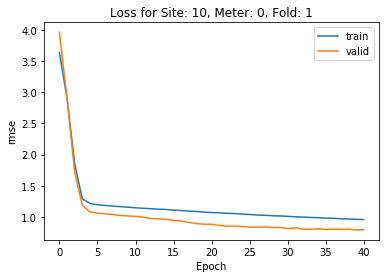

CPU times: user 15.2 s, sys: 1.3 s, total: 16.5 s
Wall time: 14.8 s
Preparing Site: 10 , meter: 0 , Fold: 2
Train on 176765 samples, validate on 58922 samples
Epoch 1/41
 - 2s - loss: 3.9797 - val_loss: 2.6799
Epoch 2/41
 - 1s - loss: 3.0852 - val_loss: 1.6469
Epoch 3/41
 - 1s - loss: 1.9938 - val_loss: 0.8338
Epoch 4/41
 - 1s - loss: 1.4202 - val_loss: 0.8110
Epoch 5/41
 - 1s - loss: 1.3003 - val_loss: 0.8625
Epoch 6/41
 - 1s - loss: 1.2633 - val_loss: 0.8758
Epoch 7/41
 - 1s - loss: 1.2448 - val_loss: 0.8777
Epoch 8/41
 - 1s - loss: 1.2310 - val_loss: 0.8742
Epoch 9/41
 - 1s - loss: 1.2194 - val_loss: 0.8731
Epoch 10/41
 - 1s - loss: 1.2131 - val_loss: 0.8731
Epoch 11/41
 - 1s - loss: 1.2046 - val_loss: 0.8738
Epoch 12/41
 - 1s - loss: 1.1939 - val_loss: 0.8713
Epoch 13/41
 - 1s - loss: 1.1891 - val_loss: 0.8636
Epoch 14/41
 - 1s - loss: 1.1788 - val_loss: 0.8666
Epoch 15/41
 - 1s - loss: 1.1701 - val_loss: 0.8653
Epoch 16/41
 - 1s - loss: 1.1634 - val_loss: 0.8653
Epoch 17/41
 - 1s 

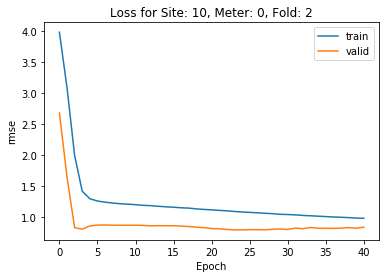

CPU times: user 15.6 s, sys: 1.38 s, total: 17 s
Wall time: 15.4 s
Preparing Site: 10 , meter: 0 , Fold: 3
Train on 176765 samples, validate on 58922 samples
Epoch 1/41
 - 2s - loss: 3.9096 - val_loss: 3.1292
Epoch 2/41
 - 1s - loss: 3.0610 - val_loss: 2.0875
Epoch 3/41
 - 1s - loss: 2.0898 - val_loss: 1.0923
Epoch 4/41
 - 1s - loss: 1.4872 - val_loss: 0.9039
Epoch 5/41
 - 1s - loss: 1.3209 - val_loss: 0.9045
Epoch 6/41
 - 1s - loss: 1.2728 - val_loss: 0.9018
Epoch 7/41
 - 1s - loss: 1.2470 - val_loss: 0.8985
Epoch 8/41
 - 1s - loss: 1.2365 - val_loss: 0.8942
Epoch 9/41
 - 1s - loss: 1.2226 - val_loss: 0.8919
Epoch 10/41
 - 1s - loss: 1.2158 - val_loss: 0.8888
Epoch 11/41
 - 1s - loss: 1.2095 - val_loss: 0.8869
Epoch 12/41
 - 1s - loss: 1.1984 - val_loss: 0.8877
Epoch 13/41
 - 1s - loss: 1.1922 - val_loss: 0.8832
Epoch 14/41
 - 1s - loss: 1.1817 - val_loss: 0.8824
Epoch 15/41
 - 1s - loss: 1.1756 - val_loss: 0.8828
Epoch 16/41
 - 1s - loss: 1.1680 - val_loss: 0.8815
Epoch 17/41
 - 1s -

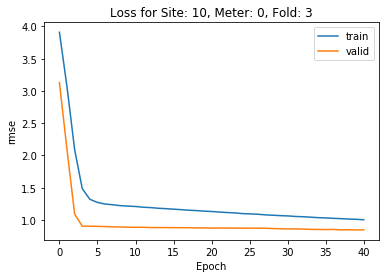

CPU times: user 15.4 s, sys: 916 ms, total: 16.3 s
Wall time: 13.5 s
Preparing Site: 10 , meter: 0 , Fold: 4
Train on 176766 samples, validate on 58921 samples
Epoch 1/41
 - 2s - loss: 3.6584 - val_loss: 3.8275
Epoch 2/41
 - 1s - loss: 2.9131 - val_loss: 2.7772
Epoch 3/41
 - 1s - loss: 1.9561 - val_loss: 1.6371
Epoch 4/41
 - 1s - loss: 1.4379 - val_loss: 1.1704
Epoch 5/41
 - 1s - loss: 1.3088 - val_loss: 1.0672
Epoch 6/41
 - 1s - loss: 1.2750 - val_loss: 1.0321
Epoch 7/41
 - 1s - loss: 1.2567 - val_loss: 1.0147
Epoch 8/41
 - 1s - loss: 1.2454 - val_loss: 0.9964
Epoch 9/41
 - 1s - loss: 1.2355 - val_loss: 0.9998
Epoch 10/41
 - 1s - loss: 1.2329 - val_loss: 0.9789
Epoch 11/41
 - 1s - loss: 1.2250 - val_loss: 0.9736
Epoch 12/41
 - 1s - loss: 1.2164 - val_loss: 0.9548
Epoch 13/41
 - 1s - loss: 1.2130 - val_loss: 0.9589
Epoch 14/41
 - 1s - loss: 1.2051 - val_loss: 0.9486
Epoch 15/41
 - 1s - loss: 1.1956 - val_loss: 0.9255
Epoch 16/41
 - 1s - loss: 1.1894 - val_loss: 0.9289
Epoch 17/41
 - 1s

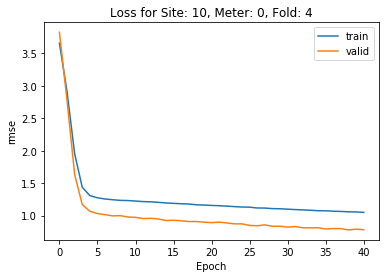

CPU times: user 15 s, sys: 827 ms, total: 15.8 s
Wall time: 12.3 s

CV RMSE for Site: 10 and Meter: 0 is 0.9713658157813542

CV RMSE for Site: 10 is 0.9713658157813542


In [13]:
for meter in df_train.meter.unique():
    print("Building Model for site_id", site_id, "and meter", meter)
        
    df_train_site_meter = df_train[df_train.meter == meter].reset_index(drop=True)
    df_test_site_meter = df_test[df_test.meter == meter].reset_index(drop=True)
    
    pred_val = np.zeros(df_train_site_meter.shape[0])
    pred_test = np.zeros(df_test_site_meter.shape[0])

    row_ids_test = df_test_site_meter.row_id
    y_train_site_meter = df_train_site_meter.log_meter_reading.values
    
    df_train_site_meter = df_train_site_meter[features]
    df_test_site_meter = df_test_site_meter[features]

    df_train_site_meter = pd.get_dummies(df_train_site_meter)
    df_test_site_meter = pd.get_dummies(df_test_site_meter)
        
    for k, (train_idx, valid_idx) in enumerate(folds.split(df_train_site_meter, y_train_site_meter)):
        print("Preparing Site:", site_id, ", meter:", meter, ", Fold:", k+1)
        
        X_train, y_train = df_train_site_meter.iloc[train_idx], y_train_site_meter[train_idx]
        X_valid, y_valid = df_train_site_meter.iloc[valid_idx], y_train_site_meter[valid_idx]
        
        X_train.dropna(axis=1, how="all", inplace=True)
        X_train = X_train.loc[:, (X_train != X_train.iloc[0]).any()]

        X_valid = X_valid[X_train.columns]
        X_test = df_test_site_meter[X_train.columns]
        
        df_means = pd.concat([X_train, X_valid, X_test], ignore_index=True).mean()
        X_train.fillna(df_means, inplace=True)
        X_valid.fillna(df_means, inplace=True)
        X_test.fillna(df_means, inplace=True)
        
        sc = MinMaxScaler()
        sc.fit(pd.concat([X_train, X_valid, X_test], ignore_index=True))
        
        X_train = np.array(sc.transform(X_train))
        X_valid = np.array(sc.transform(X_valid))
        X_test = np.array(sc.transform(X_test))
        
        model = Sequential()
        model.add(Dense(32, input_dim=X_train.shape[1], activation="relu", kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(8, activation="tanh", kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(4, activation="tanh", kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(loss=rmse, optimizer="adam")
        
        model_ffnn = model.fit(X_train, y_train, epochs=41, batch_size=1000, validation_data=(X_valid, y_valid), verbose=2, shuffle=False)

        plt.plot(model_ffnn.history["loss"])
        plt.plot(model_ffnn.history["val_loss"])
        plt.title("Loss for Site: " + str(site_id) + ", Meter: " + str(meter) + ", Fold: " + str(k+1))
        plt.ylabel("rmse")
        plt.xlabel("Epoch")
        plt.legend(["train", "valid"], loc="upper right")
        plt.show()
        
        pred_val[valid_idx] = model.predict(X_valid).ravel()
        %time pred_test += model.predict(X_test).ravel() / cv
        
        gc.collect()
        
    df_valid = pd.DataFrame({"site_id": site_id, "meter": meter, "meter_reading": np.expm1(y_train_site_meter), "pred_ffnn": np.clip(np.expm1(pred_val), 0, a_max=None)})
    df_pred = pd.DataFrame({"row_id": row_ids_test, "meter_reading": np.clip(np.expm1(pred_test), 0, a_max=None)})
    
    df_cv.append(df_valid)
    df_preds.append(df_pred)
    
    gc.collect()
    
    print("\nCV RMSE for Site:", site_id, "and Meter:", meter, "is", np.sqrt(mean_squared_error(np.log1p(df_valid.meter_reading), np.log1p(df_valid.pred_ffnn))))

df_cv = pd.concat(df_cv)
print("\nCV RMSE for Site:", site_id, "is", np.sqrt(mean_squared_error(np.log1p(df_cv.meter_reading), np.log1p(df_cv.pred_ffnn))))


In [14]:
df_preds = pd.concat(df_preds)
df_preds.to_csv("../sub/ffnn_pred_site_" + str(site_id) + ".csv", index=False)